# Autism Spectrum Disorder Detection - ViT and CNN Models Training

This notebook prepares data from the AutismDataset folder and trains Vision Transformer and various CNN architectures for autism spectrum disorder detection:
- Vision Transformer (ViT)
- AlexNet
- MobileNet V2
- DenseNet-121
- RegNet

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

We'll create DataFrames for train, validation, and test sets from the AutismDataset folder structure.

In [2]:
# Base paths
base_path = '/kaggle/input/autism-image-data/AutismDataset'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

def create_dataframe_from_flat_directory(directory_path, split_name):
    """
    Create DataFrame from flat directory structure (train/test)
    Files are named like: Autistic.X.jpg, Non_Autistic.X.jpg
    """
    data = []
    
    # Get all jpg files
    all_files = glob.glob(os.path.join(directory_path, '*.jpg'))
    
    for file_path in all_files:
        filename = os.path.basename(file_path)
        
        # Determine label from filename
        if filename.startswith('Autistic.'):
            label = 'Autistic'
        elif filename.startswith('Non_Autistic.'):
            label = 'Non_Autistic'
        else:
            continue  # Skip files that don't match our pattern
        
        data.append({
            'image_path': file_path,
            'labels': label,
            'split': split_name
        })
    
    return pd.DataFrame(data)

def create_dataframe_from_subdirectory(directory_path, split_name):
    """
    Create DataFrame from subdirectory structure (valid)
    Structure: valid/Autistic/, valid/Non_Autistic/
    """
    data = []
    
    # Process Autistic subdirectory
    autistic_path = os.path.join(directory_path, 'Autistic')
    if os.path.exists(autistic_path):
        autistic_files = glob.glob(os.path.join(autistic_path, '*.jpg'))
        for file_path in autistic_files:
            data.append({
                'image_path': file_path,
                'labels': 'Autistic',
                'split': split_name
            })
    
    # Process Non_Autistic subdirectory
    non_autistic_path = os.path.join(directory_path, 'Non_Autistic')
    if os.path.exists(non_autistic_path):
        non_autistic_files = glob.glob(os.path.join(non_autistic_path, '*.jpg'))
        for file_path in non_autistic_files:
            data.append({
                'image_path': file_path,
                'labels': 'Non_Autistic',
                'split': split_name
            })
    
    return pd.DataFrame(data)

# Create DataFrames for each split
print("\nCreating DataFrames...")
train_df = create_dataframe_from_flat_directory(train_path, 'train')
valid_df = create_dataframe_from_subdirectory(valid_path, 'valid')
test_df = create_dataframe_from_flat_directory(test_path, 'test')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(valid_df) + len(test_df)}")

if len(train_df) > 0:
    print(f"\nLabel distribution in training set:")
    print(train_df['labels'].value_counts())

if len(valid_df) > 0:
    print(f"\nLabel distribution in validation set:")
    print(valid_df['labels'].value_counts())

if len(test_df) > 0:
    print(f"\nLabel distribution in test set:")
    print(test_df['labels'].value_counts())


Creating DataFrames...
Training samples: 2540
Validation samples: 100
Test samples: 300
Total samples: 2940

Label distribution in training set:
labels
Non_Autistic    1270
Autistic        1270
Name: count, dtype: int64

Label distribution in validation set:
labels
Autistic        50
Non_Autistic    50
Name: count, dtype: int64

Label distribution in test set:
labels
Non_Autistic    150
Autistic        150
Name: count, dtype: int64


## Data Transformations

Define image transformations for training and validation/testing. For ViT models, we use specific image sizes.

In [3]:
# Data transformations for CNN models - No augmentation
train_transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

val_test_transform_cnn = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

## Dataset & DataLoader Classes

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class AutismDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with image_path and labels columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['labels'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['labels'])
        
        self.image_paths = self.data['image_path'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

def create_dataloaders(train_df, val_df, test_df, train_transform, val_test_transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create datasets and dataloaders for training, validation, and testing
    """
    # Create training dataset and fit label encoder
    train_dataset = AutismDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = AutismDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = AutismDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader, le

## Model Training Framework

In [5]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving"""
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_acc = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model
                if phase == 'val' and epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation accuracy: {best_val_acc:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation accuracy: {best_val_acc:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None):
        """Evaluate model on test set"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / len(test_loader)
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=['Autistic', 'Non_Autistic']))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        return test_acc, all_preds, all_labels
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

## Model Definitions

In [6]:
def create_vit_model(architecture='vit_b_16', num_classes=2, pretrained=True):
    """Create Vision Transformer model for binary classification"""
    if architecture == 'vit_b_16':
        model = models.vit_b_16(pretrained=pretrained)
    elif architecture == 'vit_l_16':
        model = models.vit_l_16(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be 'vit_b_16' or 'vit_l_16'")
    
    # Modify classifier head
    num_features = model.heads.head.in_features
    model.heads.head = nn.Linear(num_features, num_classes)
    
    return model

def create_alexnet_model(num_classes=2, pretrained=True):
    """Create AlexNet model for binary classification"""
    model = models.alexnet(pretrained=pretrained)
    
    # Modify classifier
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    return model

def create_mobilenet_model(version='v2', num_classes=2, pretrained=True):
    """Create MobileNet model (v2 or v3) for binary classification"""
    if version == 'v2':
        model = models.mobilenet_v2(pretrained=pretrained)
        # Modify classifier
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif version == 'v3_large':
        model = models.mobilenet_v3_large(pretrained=pretrained)
        # Modify classifier
        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_features, num_classes)
    elif version == 'v3_small':
        model = models.mobilenet_v3_small(pretrained=pretrained)
        # Modify classifier
        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Version must be 'v2', 'v3_large', or 'v3_small'")
    
    return model

def create_regnet_model(architecture='x_400mf', num_classes=2, pretrained=True):
    """Create RegNet model for binary classification"""
    if architecture == 'x_400mf':
        model = models.regnet_x_400mf(pretrained=pretrained)
    elif architecture == 'x_800mf':
        model = models.regnet_x_800mf(pretrained=pretrained)
    elif architecture == 'y_400mf':
        model = models.regnet_y_400mf(pretrained=pretrained)
    elif architecture == 'y_800mf':
        model = models.regnet_y_800mf(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be 'x_400mf', 'x_800mf', 'y_400mf', or 'y_800mf'")
    
    # Modify classifier
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

def create_densenet_model(architecture='121', num_classes=2, pretrained=True):
    """Create DenseNet model (121 or 169) for binary classification"""
    if architecture == '121':
        model = models.densenet121(pretrained=pretrained)
    elif architecture == '169':
        model = models.densenet169(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be '121' or '169'")
    
    # Modify classifier
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    
    return model

## Configure GPU

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.9 GB


## Create DataLoaders for CNN Models

In [8]:
# Create CNN dataloaders
train_loader_cnn, val_loader_cnn, test_loader_cnn, label_encoder = create_dataloaders(
    train_df, valid_df, test_df, 
    train_transform_cnn, val_test_transform_cnn,
    batch_size=32, num_workers=4
)

print(f"CNN DataLoaders created:")
print(f"Training batches: {len(train_loader_cnn)}")
print(f"Validation batches: {len(val_loader_cnn)}")
print(f"Test batches: {len(test_loader_cnn)}")
print(f"Classes: {label_encoder.classes_}")

CNN DataLoaders created:
Training batches: 79
Validation batches: 4
Test batches: 10
Classes: ['Autistic' 'Non_Autistic']


## Create DataLoaders for ViT Model

In [9]:
# Create ViT dataloaders (larger image size)
train_loader_vit, val_loader_vit, test_loader_vit, _ = create_dataloaders(
    train_df, valid_df, test_df, 
    train_transform_cnn, val_test_transform_cnn,
    batch_size=16, num_workers=4  # Smaller batch size for ViT due to memory requirements
)

print(f"ViT DataLoaders created:")
print(f"Training batches: {len(train_loader_vit)}")
print(f"Validation batches: {len(val_loader_vit)}")
print(f"Test batches: {len(test_loader_vit)}")

ViT DataLoaders created:
Training batches: 158
Validation batches: 7
Test batches: 19


## 1. Vision Transformer (ViT-B/16) Training

In [10]:
# Create and train ViT-B/16
print("Creating Vision Transformer (ViT-B/16) model...")
vit_b16_model = create_vit_model('vit_b_16')
vit_b16_trainer = ModelTrainer(vit_b16_model, train_loader_vit, val_loader_vit, test_loader_vit, device)

Creating Vision Transformer (ViT-B/16) model...


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 202MB/s]


In [11]:
# Train ViT-B/16
print("Training Vision Transformer (ViT-B/16)...")
trained_vit_b16 = vit_b16_trainer.train_model(num_epochs=25, lr=0.0001, model_name="vit_b16")

Training Vision Transformer (ViT-B/16)...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 158/158 [00:52<00:00,  3.04it/s, Loss=0.5065, Acc=0.7500]


Train Loss: 0.5065 Acc: 0.7500


Val : 100%|██████████| 7/7 [00:00<00:00,  7.68it/s, Loss=0.4644, Acc=0.7900]


Val Loss: 0.4644 Acc: 0.7900
✓ New best model saved with validation accuracy: 0.7900

Epoch 2/25
----------


Train : 100%|██████████| 158/158 [00:50<00:00,  3.11it/s, Loss=0.3377, Acc=0.8485]


Train Loss: 0.3377 Acc: 0.8485


Val : 100%|██████████| 7/7 [00:00<00:00,  8.04it/s, Loss=0.4536, Acc=0.7900]


Val Loss: 0.4536 Acc: 0.7900

Epoch 3/25
----------


Train : 100%|██████████| 158/158 [00:50<00:00,  3.11it/s, Loss=0.2490, Acc=0.8995]


Train Loss: 0.2490 Acc: 0.8995


Val : 100%|██████████| 7/7 [00:00<00:00,  8.08it/s, Loss=0.4853, Acc=0.7700]


Val Loss: 0.4853 Acc: 0.7700

Epoch 4/25
----------


Train : 100%|██████████| 158/158 [00:50<00:00,  3.11it/s, Loss=0.1735, Acc=0.9248]


Train Loss: 0.1735 Acc: 0.9248


Val : 100%|██████████| 7/7 [00:00<00:00,  8.11it/s, Loss=0.4850, Acc=0.8200]


Val Loss: 0.4850 Acc: 0.8200
✓ New best model saved with validation accuracy: 0.8200

Epoch 5/25
----------


Train : 100%|██████████| 158/158 [00:50<00:00,  3.11it/s, Loss=0.1156, Acc=0.9565]


Train Loss: 0.1156 Acc: 0.9565


Val : 100%|██████████| 7/7 [00:00<00:00,  8.25it/s, Loss=0.6568, Acc=0.8100]


Val Loss: 0.6568 Acc: 0.8100

Epoch 6/25
----------


Train : 100%|██████████| 158/158 [00:50<00:00,  3.11it/s, Loss=0.1196, Acc=0.9482]


Train Loss: 0.1196 Acc: 0.9482


Val : 100%|██████████| 7/7 [00:00<00:00,  8.26it/s, Loss=0.6270, Acc=0.7400]


Val Loss: 0.6270 Acc: 0.7400

Epoch 7/25
----------


Train : 100%|██████████| 158/158 [00:50<00:00,  3.11it/s, Loss=0.0748, Acc=0.9719]


Train Loss: 0.0748 Acc: 0.9719


Val : 100%|██████████| 7/7 [00:00<00:00,  8.31it/s, Loss=0.4993, Acc=0.7900]


Val Loss: 0.4993 Acc: 0.7900

Epoch 8/25
----------


Train : 100%|██████████| 158/158 [00:50<00:00,  3.11it/s, Loss=0.0865, Acc=0.9644]


Train Loss: 0.0865 Acc: 0.9644


Val : 100%|██████████| 7/7 [00:00<00:00,  8.17it/s, Loss=0.5156, Acc=0.8000]


Val Loss: 0.5156 Acc: 0.8000

Epoch 9/25
----------


Train : 100%|██████████| 158/158 [00:50<00:00,  3.11it/s, Loss=0.0659, Acc=0.9771]


Train Loss: 0.0659 Acc: 0.9771


Val : 100%|██████████| 7/7 [00:00<00:00,  7.95it/s, Loss=0.4298, Acc=0.8100]

Val Loss: 0.4298 Acc: 0.8100
Early stopping triggered after 9 epochs
Training complete in 7m 48s
Best validation accuracy: 0.8200


Evaluating on test set...


100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


Test Accuracy: 84.67%
Test Loss: 0.4425

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.88      0.81      0.84       150
Non_Autistic       0.82      0.89      0.85       150

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300


Confusion Matrix:
[[121  29]
 [ 17 133]]


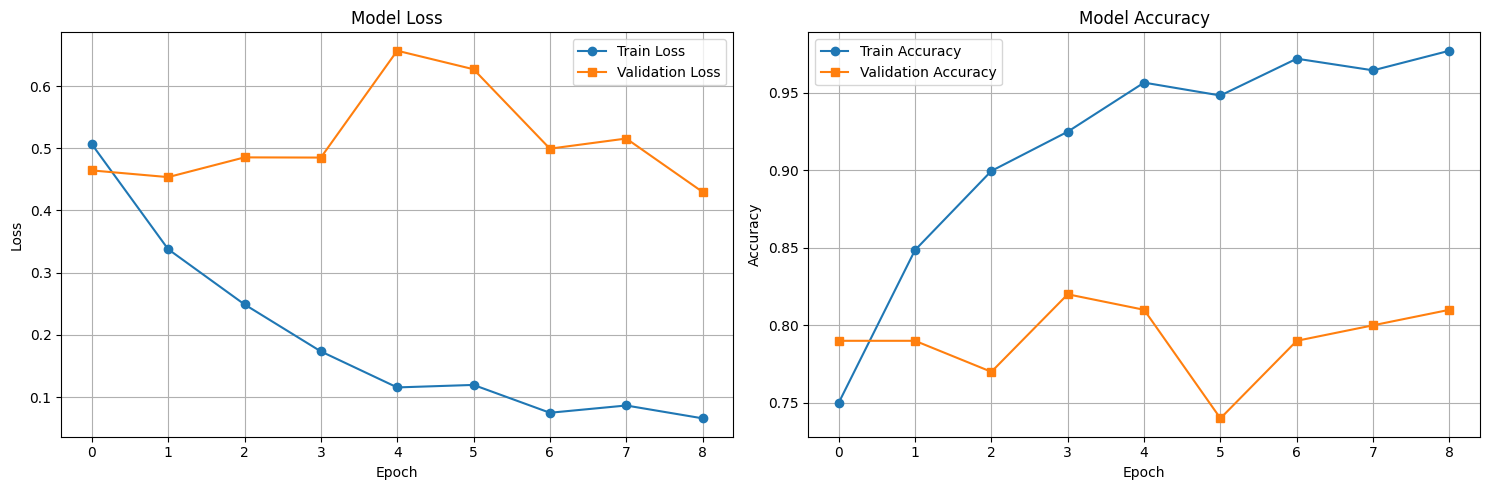

In [12]:
# Evaluate ViT-B/16
vit_b16_test_acc, vit_b16_preds, vit_b16_labels = vit_b16_trainer.evaluate_model()
vit_b16_trainer.plot_training_history()

## 2. AlexNet Training

In [13]:
# Create and train AlexNet
print("Creating AlexNet model...")
alexnet_model = create_alexnet_model()
alexnet_trainer = ModelTrainer(alexnet_model, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)

Creating AlexNet model...


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 200MB/s]


In [14]:
# Train AlexNet
print("Training AlexNet...")
trained_alexnet = alexnet_trainer.train_model(num_epochs=25, model_name="alexnet")

Training AlexNet...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 13.43it/s, Loss=0.8026, Acc=0.5237]


Train Loss: 0.8026 Acc: 0.5237


Val : 100%|██████████| 4/4 [00:00<00:00,  9.13it/s, Loss=0.6941, Acc=0.5000]


Val Loss: 0.6941 Acc: 0.5000
✓ New best model saved with validation accuracy: 0.5000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 14.85it/s, Loss=0.6948, Acc=0.5079]


Train Loss: 0.6948 Acc: 0.5079


Val : 100%|██████████| 4/4 [00:00<00:00,  9.14it/s, Loss=0.6985, Acc=0.5000]


Val Loss: 0.6985 Acc: 0.5000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 14.59it/s, Loss=0.7170, Acc=0.5004]


Train Loss: 0.7170 Acc: 0.5004


Val : 100%|██████████| 4/4 [00:00<00:00, 10.07it/s, Loss=0.6931, Acc=0.5000]


Val Loss: 0.6931 Acc: 0.5000

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 15.19it/s, Loss=0.6949, Acc=0.4826]


Train Loss: 0.6949 Acc: 0.4826


Val : 100%|██████████| 4/4 [00:00<00:00,  9.78it/s, Loss=0.6936, Acc=0.5000]


Val Loss: 0.6936 Acc: 0.5000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 14.93it/s, Loss=0.6940, Acc=0.4988]


Train Loss: 0.6940 Acc: 0.4988


Val : 100%|██████████| 4/4 [00:00<00:00, 10.11it/s, Loss=0.6932, Acc=0.5000]


Val Loss: 0.6932 Acc: 0.5000

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:05<00:00, 14.15it/s, Loss=0.7621, Acc=0.5055]


Train Loss: 0.7621 Acc: 0.5055


Val : 100%|██████████| 4/4 [00:00<00:00,  9.89it/s, Loss=0.7824, Acc=0.5000]

Val Loss: 0.7824 Acc: 0.5000
Early stopping triggered after 6 epochs
Training complete in 0m 36s
Best validation accuracy: 0.5000


Evaluating on test set...


100%|██████████| 10/10 [00:00<00:00, 12.65it/s]


Test Accuracy: 50.00%
Test Loss: 0.6945

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.00      0.00      0.00       150
Non_Autistic       0.50      1.00      0.67       150

    accuracy                           0.50       300
   macro avg       0.25      0.50      0.33       300
weighted avg       0.25      0.50      0.33       300


Confusion Matrix:
[[  0 150]
 [  0 150]]


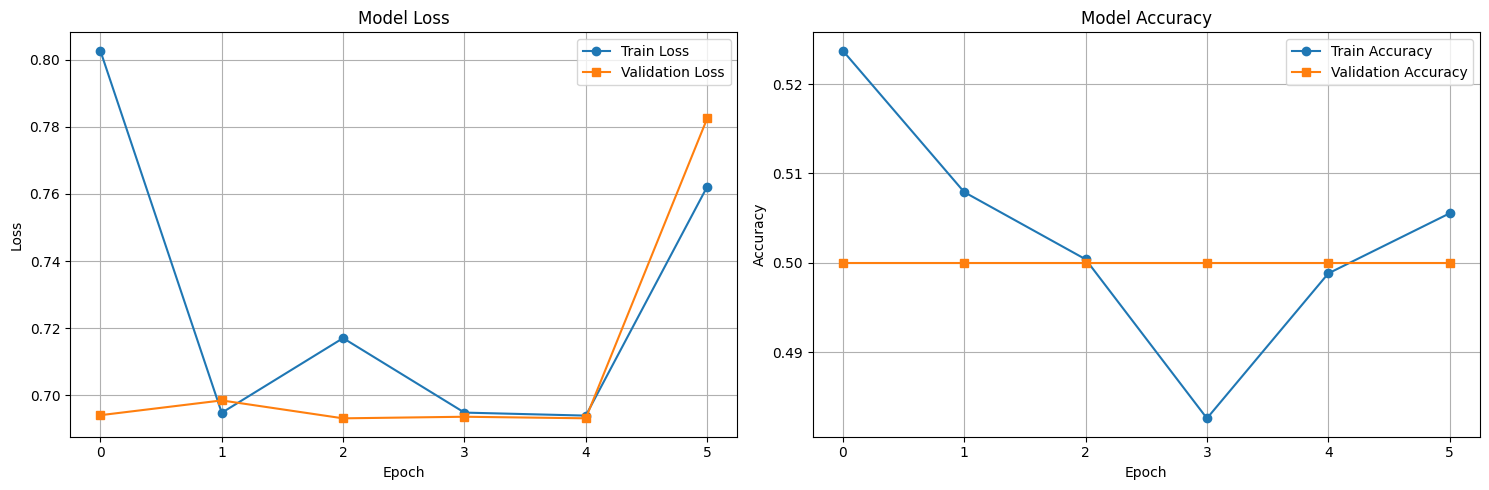

In [15]:
# Evaluate AlexNet
alexnet_test_acc, alexnet_preds, alexnet_labels = alexnet_trainer.evaluate_model()
alexnet_trainer.plot_training_history()

## 3. MobileNet V2 Training

In [16]:
# Create and train MobileNet V2
print("Creating MobileNet V2 model...")
mobilenet_v2_model = create_mobilenet_model('v2')
mobilenet_v2_trainer = ModelTrainer(mobilenet_v2_model, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Creating MobileNet V2 model...


100%|██████████| 13.6M/13.6M [00:00<00:00, 167MB/s]


In [17]:
# Train MobileNet V2
print("Training MobileNet V2...")
trained_mobilenet_v2 = mobilenet_v2_trainer.train_model(num_epochs=25, model_name="mobilenet_v2")

Training MobileNet V2...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:07<00:00, 11.02it/s, Loss=0.4903, Acc=0.7670]


Train Loss: 0.4903 Acc: 0.7670


Val : 100%|██████████| 4/4 [00:00<00:00,  8.19it/s, Loss=0.4807, Acc=0.7600]


Val Loss: 0.4807 Acc: 0.7600
✓ New best model saved with validation accuracy: 0.7600

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.41it/s, Loss=0.3445, Acc=0.8501]


Train Loss: 0.3445 Acc: 0.8501


Val : 100%|██████████| 4/4 [00:00<00:00,  8.53it/s, Loss=0.3921, Acc=0.8500]


Val Loss: 0.3921 Acc: 0.8500
✓ New best model saved with validation accuracy: 0.8500

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.41it/s, Loss=0.2679, Acc=0.8956]


Train Loss: 0.2679 Acc: 0.8956


Val : 100%|██████████| 4/4 [00:00<00:00,  9.46it/s, Loss=0.3492, Acc=0.8800]


Val Loss: 0.3492 Acc: 0.8800
✓ New best model saved with validation accuracy: 0.8800

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.35it/s, Loss=0.2441, Acc=0.8964]


Train Loss: 0.2441 Acc: 0.8964


Val : 100%|██████████| 4/4 [00:00<00:00,  9.24it/s, Loss=0.6699, Acc=0.7500]


Val Loss: 0.6699 Acc: 0.7500

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.33it/s, Loss=0.1858, Acc=0.9272]


Train Loss: 0.1858 Acc: 0.9272


Val : 100%|██████████| 4/4 [00:00<00:00,  9.63it/s, Loss=0.4571, Acc=0.8100]


Val Loss: 0.4571 Acc: 0.8100

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.43it/s, Loss=0.1454, Acc=0.9446]


Train Loss: 0.1454 Acc: 0.9446


Val : 100%|██████████| 4/4 [00:00<00:00,  9.30it/s, Loss=0.5447, Acc=0.7500]


Val Loss: 0.5447 Acc: 0.7500

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.33it/s, Loss=0.1115, Acc=0.9541]


Train Loss: 0.1115 Acc: 0.9541


Val : 100%|██████████| 4/4 [00:00<00:00,  9.05it/s, Loss=0.4018, Acc=0.8400]


Val Loss: 0.4018 Acc: 0.8400

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.39it/s, Loss=0.1115, Acc=0.9533]


Train Loss: 0.1115 Acc: 0.9533


Val : 100%|██████████| 4/4 [00:00<00:00,  9.06it/s, Loss=0.5942, Acc=0.8100]

Val Loss: 0.5942 Acc: 0.8100
Early stopping triggered after 8 epochs
Training complete in 0m 60s
Best validation accuracy: 0.8800


Evaluating on test set...


100%|██████████| 10/10 [00:00<00:00, 11.85it/s]


Test Accuracy: 82.33%
Test Loss: 0.4146

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.76      0.95      0.84       150
Non_Autistic       0.94      0.69      0.80       150

    accuracy                           0.82       300
   macro avg       0.85      0.82      0.82       300
weighted avg       0.85      0.82      0.82       300


Confusion Matrix:
[[143   7]
 [ 46 104]]


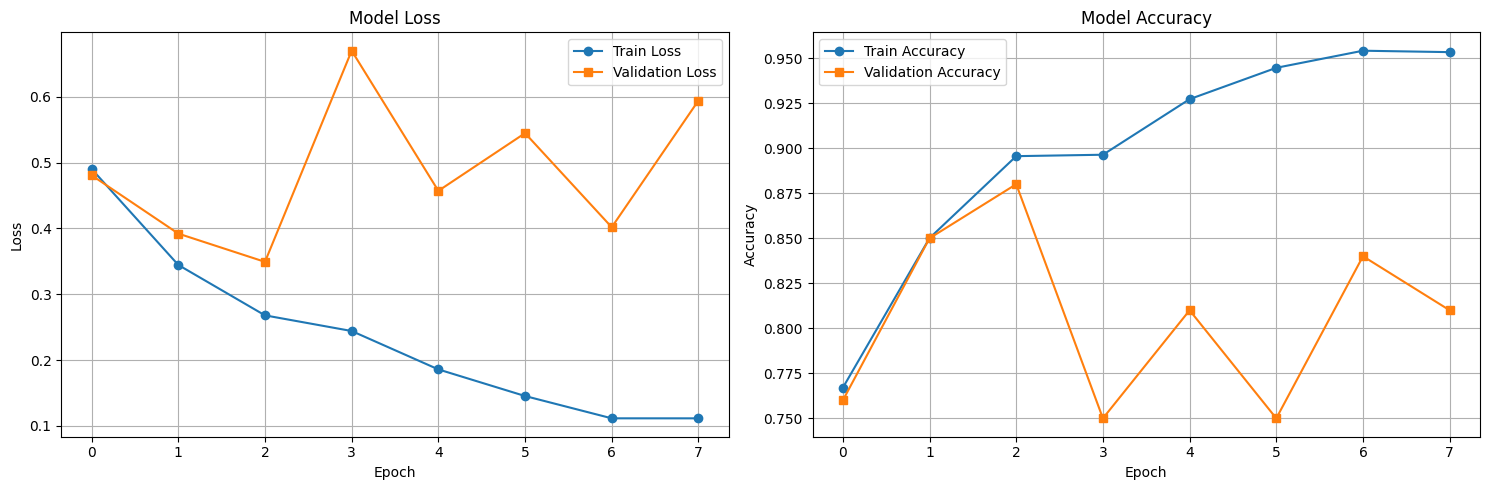

In [18]:
# Evaluate MobileNet V2
mobilenet_v2_test_acc, mobilenet_v2_preds, mobilenet_v2_labels = mobilenet_v2_trainer.evaluate_model()
mobilenet_v2_trainer.plot_training_history()

## 4. MobileNet V3 Large Training

In [19]:
# Create and train MobileNet V3 Large
print("Creating MobileNet V3 Large model...")
mobilenet_v3_large_model = create_mobilenet_model('v3_large')
mobilenet_v3_large_trainer = ModelTrainer(mobilenet_v3_large_model, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


Creating MobileNet V3 Large model...


100%|██████████| 21.1M/21.1M [00:00<00:00, 173MB/s]


In [20]:
# Train MobileNet V3 Large
print("Training MobileNet V3 Large...")
trained_mobilenet_v3_large = mobilenet_v3_large_trainer.train_model(num_epochs=25, model_name="mobilenet_v3_large")

Training MobileNet V3 Large...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.37it/s, Loss=0.4592, Acc=0.7812]


Train Loss: 0.4592 Acc: 0.7812


Val : 100%|██████████| 4/4 [00:00<00:00,  8.35it/s, Loss=1.9808, Acc=0.5900]


Val Loss: 1.9808 Acc: 0.5900
✓ New best model saved with validation accuracy: 0.5900

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.77it/s, Loss=0.3166, Acc=0.8703]


Train Loss: 0.3166 Acc: 0.8703


Val : 100%|██████████| 4/4 [00:00<00:00,  9.39it/s, Loss=2.4115, Acc=0.6200]


Val Loss: 2.4115 Acc: 0.6200
✓ New best model saved with validation accuracy: 0.6200

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.79it/s, Loss=0.2004, Acc=0.9244]


Train Loss: 0.2004 Acc: 0.9244


Val : 100%|██████████| 4/4 [00:00<00:00,  9.26it/s, Loss=0.6573, Acc=0.7700]


Val Loss: 0.6573 Acc: 0.7700
✓ New best model saved with validation accuracy: 0.7700

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.56it/s, Loss=0.1568, Acc=0.9403]


Train Loss: 0.1568 Acc: 0.9403


Val : 100%|██████████| 4/4 [00:00<00:00,  9.02it/s, Loss=1.0446, Acc=0.6800]


Val Loss: 1.0446 Acc: 0.6800

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.65it/s, Loss=0.1335, Acc=0.9486]


Train Loss: 0.1335 Acc: 0.9486


Val : 100%|██████████| 4/4 [00:00<00:00,  9.02it/s, Loss=0.7149, Acc=0.8300]


Val Loss: 0.7149 Acc: 0.8300
✓ New best model saved with validation accuracy: 0.8300

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.80it/s, Loss=0.0965, Acc=0.9624]


Train Loss: 0.0965 Acc: 0.9624


Val : 100%|██████████| 4/4 [00:00<00:00,  9.08it/s, Loss=0.7037, Acc=0.7500]


Val Loss: 0.7037 Acc: 0.7500

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.68it/s, Loss=0.0729, Acc=0.9755]


Train Loss: 0.0729 Acc: 0.9755


Val : 100%|██████████| 4/4 [00:00<00:00,  8.63it/s, Loss=0.4852, Acc=0.8100]


Val Loss: 0.4852 Acc: 0.8100

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.83it/s, Loss=0.0728, Acc=0.9699]


Train Loss: 0.0728 Acc: 0.9699


Val : 100%|██████████| 4/4 [00:00<00:00,  8.35it/s, Loss=0.8379, Acc=0.8300]


Val Loss: 0.8379 Acc: 0.8300

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.92it/s, Loss=0.0527, Acc=0.9806]


Train Loss: 0.0527 Acc: 0.9806


Val : 100%|██████████| 4/4 [00:00<00:00,  9.12it/s, Loss=0.6764, Acc=0.8400]


Val Loss: 0.6764 Acc: 0.8400
✓ New best model saved with validation accuracy: 0.8400

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.48it/s, Loss=0.0317, Acc=0.9877]


Train Loss: 0.0317 Acc: 0.9877


Val : 100%|██████████| 4/4 [00:00<00:00,  8.92it/s, Loss=0.6856, Acc=0.8200]


Val Loss: 0.6856 Acc: 0.8200

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.95it/s, Loss=0.0328, Acc=0.9885]


Train Loss: 0.0328 Acc: 0.9885


Val : 100%|██████████| 4/4 [00:00<00:00,  9.56it/s, Loss=0.6774, Acc=0.8300]


Val Loss: 0.6774 Acc: 0.8300

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.95it/s, Loss=0.0616, Acc=0.9782]


Train Loss: 0.0616 Acc: 0.9782


Val : 100%|██████████| 4/4 [00:00<00:00,  9.18it/s, Loss=0.7702, Acc=0.7700]


Val Loss: 0.7702 Acc: 0.7700

Epoch 13/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.87it/s, Loss=0.0480, Acc=0.9834]


Train Loss: 0.0480 Acc: 0.9834


Val : 100%|██████████| 4/4 [00:00<00:00,  9.39it/s, Loss=0.7160, Acc=0.7900]


Val Loss: 0.7160 Acc: 0.7900

Epoch 14/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 12.85it/s, Loss=0.0461, Acc=0.9830]


Train Loss: 0.0461 Acc: 0.9830


Val : 100%|██████████| 4/4 [00:00<00:00,  9.49it/s, Loss=1.2670, Acc=0.7600]

Val Loss: 1.2670 Acc: 0.7600
Early stopping triggered after 14 epochs
Training complete in 1m 33s
Best validation accuracy: 0.8400


Evaluating on test set...


100%|██████████| 10/10 [00:00<00:00, 11.96it/s]


Test Accuracy: 88.67%
Test Loss: 0.3666

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.89      0.89      0.89       150
Non_Autistic       0.89      0.89      0.89       150

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300


Confusion Matrix:
[[133  17]
 [ 17 133]]


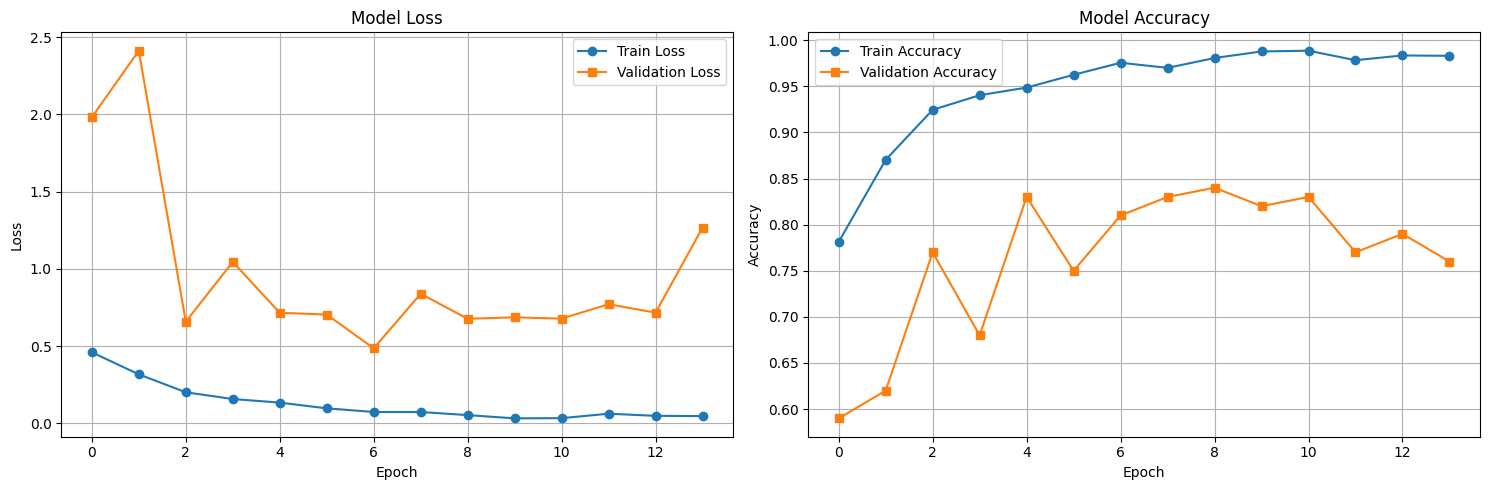

In [21]:
# Evaluate MobileNet V3 Large
mobilenet_v3_large_test_acc, mobilenet_v3_large_preds, mobilenet_v3_large_labels = mobilenet_v3_large_trainer.evaluate_model()
mobilenet_v3_large_trainer.plot_training_history()

## 5. RegNet X-400MF Training

In [22]:
# Create and train RegNet X-400MF
print("Creating RegNet X-400MF model...")
regnet_x_400mf_model = create_regnet_model('x_400mf')
regnet_x_400mf_trainer = ModelTrainer(regnet_x_400mf_model, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)

Creating RegNet X-400MF model...


Downloading: "https://download.pytorch.org/models/regnet_x_400mf-adf1edd5.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-adf1edd5.pth
100%|██████████| 21.3M/21.3M [00:00<00:00, 208MB/s]


In [23]:
# Train RegNet X-400MF
print("Training RegNet X-400MF...")
trained_regnet_x_400mf = regnet_x_400mf_trainer.train_model(num_epochs=25, model_name="regnet_x_400mf")

Training RegNet X-400MF...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.46it/s, Loss=0.4701, Acc=0.7793]


Train Loss: 0.4701 Acc: 0.7793


Val : 100%|██████████| 4/4 [00:00<00:00,  8.53it/s, Loss=0.5340, Acc=0.7400]


Val Loss: 0.5340 Acc: 0.7400
✓ New best model saved with validation accuracy: 0.7400

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.54it/s, Loss=0.2605, Acc=0.8904]


Train Loss: 0.2605 Acc: 0.8904


Val : 100%|██████████| 4/4 [00:00<00:00,  8.15it/s, Loss=0.4023, Acc=0.8300]


Val Loss: 0.4023 Acc: 0.8300
✓ New best model saved with validation accuracy: 0.8300

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.53it/s, Loss=0.1940, Acc=0.9244]


Train Loss: 0.1940 Acc: 0.9244


Val : 100%|██████████| 4/4 [00:00<00:00,  8.49it/s, Loss=0.4896, Acc=0.7900]


Val Loss: 0.4896 Acc: 0.7900

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.52it/s, Loss=0.1378, Acc=0.9422]


Train Loss: 0.1378 Acc: 0.9422


Val : 100%|██████████| 4/4 [00:00<00:00,  8.95it/s, Loss=0.6944, Acc=0.7700]


Val Loss: 0.6944 Acc: 0.7700

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.34it/s, Loss=0.1484, Acc=0.9387]


Train Loss: 0.1484 Acc: 0.9387


Val : 100%|██████████| 4/4 [00:00<00:00,  8.86it/s, Loss=0.4453, Acc=0.8900]


Val Loss: 0.4453 Acc: 0.8900
✓ New best model saved with validation accuracy: 0.8900

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.72it/s, Loss=0.0806, Acc=0.9699]


Train Loss: 0.0806 Acc: 0.9699


Val : 100%|██████████| 4/4 [00:00<00:00,  8.18it/s, Loss=0.7637, Acc=0.8200]


Val Loss: 0.7637 Acc: 0.8200

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.57it/s, Loss=0.1039, Acc=0.9648]


Train Loss: 0.1039 Acc: 0.9648


Val : 100%|██████████| 4/4 [00:00<00:00,  8.75it/s, Loss=0.6188, Acc=0.8400]


Val Loss: 0.6188 Acc: 0.8400

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.38it/s, Loss=0.0733, Acc=0.9711]


Train Loss: 0.0733 Acc: 0.9711


Val : 100%|██████████| 4/4 [00:00<00:00,  8.93it/s, Loss=1.0722, Acc=0.7700]


Val Loss: 1.0722 Acc: 0.7700

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.48it/s, Loss=0.0849, Acc=0.9688]


Train Loss: 0.0849 Acc: 0.9688


Val : 100%|██████████| 4/4 [00:00<00:00,  8.93it/s, Loss=0.6461, Acc=0.8100]


Val Loss: 0.6461 Acc: 0.8100

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:06<00:00, 11.68it/s, Loss=0.0700, Acc=0.9759]


Train Loss: 0.0700 Acc: 0.9759


Val : 100%|██████████| 4/4 [00:00<00:00,  8.67it/s, Loss=0.8562, Acc=0.7400]

Val Loss: 0.8562 Acc: 0.7400
Early stopping triggered after 10 epochs
Training complete in 1m 14s
Best validation accuracy: 0.8900


Evaluating on test set...


100%|██████████| 10/10 [00:00<00:00, 11.46it/s]


Test Accuracy: 84.67%
Test Loss: 0.3671

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.80      0.93      0.86       150
Non_Autistic       0.91      0.77      0.83       150

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300


Confusion Matrix:
[[139  11]
 [ 35 115]]


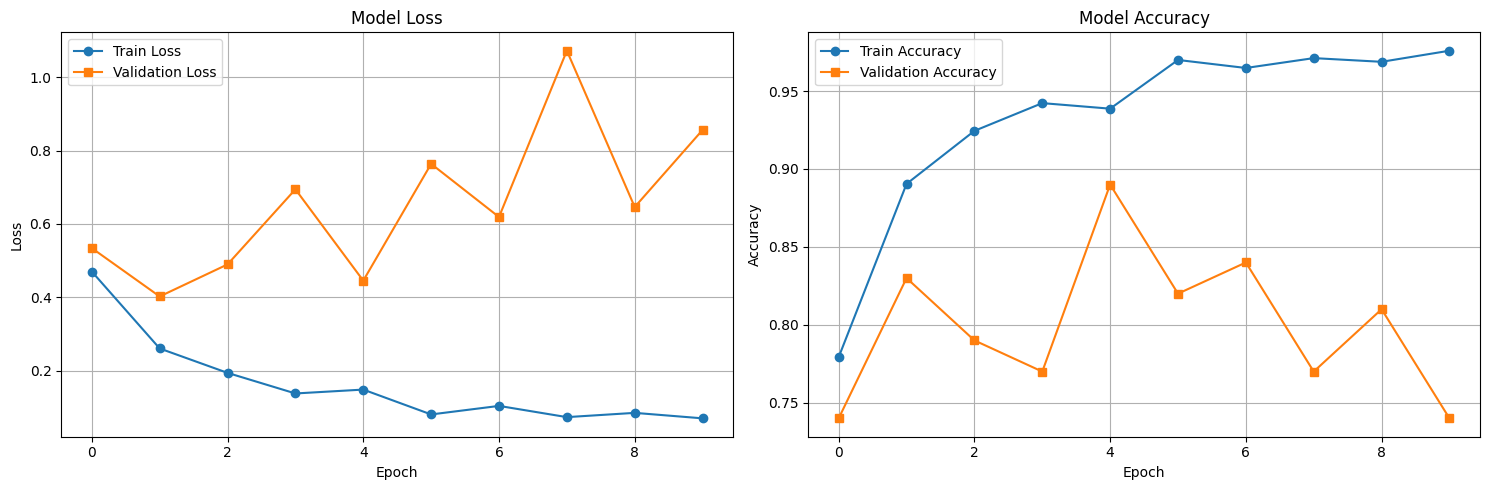

In [24]:
# Evaluate RegNet X-400MF
regnet_x_400mf_test_acc, regnet_x_400mf_preds, regnet_x_400mf_labels = regnet_x_400mf_trainer.evaluate_model()
regnet_x_400mf_trainer.plot_training_history()

## 6. DenseNet-121 Training

In [25]:
# Create and train DenseNet-121
print("Creating DenseNet-121 model...")
densenet121_model = create_densenet_model('121')
densenet121_trainer = ModelTrainer(densenet121_model, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)

Creating DenseNet-121 model...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 141MB/s]


In [26]:
# Train DenseNet-121
print("Training DenseNet-121...")
trained_densenet121 = densenet121_trainer.train_model(num_epochs=25, model_name="densenet121")

Training DenseNet-121...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.34it/s, Loss=0.5099, Acc=0.7536]


Train Loss: 0.5099 Acc: 0.7536


Val : 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Loss=0.6003, Acc=0.7200]


Val Loss: 0.6003 Acc: 0.7200
✓ New best model saved with validation accuracy: 0.7200

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.41it/s, Loss=0.4119, Acc=0.8050]


Train Loss: 0.4119 Acc: 0.8050


Val : 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, Loss=0.4452, Acc=0.8000]


Val Loss: 0.4452 Acc: 0.8000
✓ New best model saved with validation accuracy: 0.8000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.42it/s, Loss=0.3611, Acc=0.8465]


Train Loss: 0.3611 Acc: 0.8465


Val : 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, Loss=0.4707, Acc=0.7700]


Val Loss: 0.4707 Acc: 0.7700

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.39it/s, Loss=0.3480, Acc=0.8457]


Train Loss: 0.3480 Acc: 0.8457


Val : 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, Loss=0.4165, Acc=0.7800]


Val Loss: 0.4165 Acc: 0.7800

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.33it/s, Loss=0.3132, Acc=0.8667]


Train Loss: 0.3132 Acc: 0.8667


Val : 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, Loss=0.4300, Acc=0.8500]


Val Loss: 0.4300 Acc: 0.8500
✓ New best model saved with validation accuracy: 0.8500

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.40it/s, Loss=0.2567, Acc=0.8916]


Train Loss: 0.2567 Acc: 0.8916


Val : 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, Loss=0.6868, Acc=0.7000]


Val Loss: 0.6868 Acc: 0.7000

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.41it/s, Loss=0.2511, Acc=0.8932]


Train Loss: 0.2511 Acc: 0.8932


Val : 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, Loss=0.5338, Acc=0.8000]


Val Loss: 0.5338 Acc: 0.8000

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.41it/s, Loss=0.2242, Acc=0.9035]


Train Loss: 0.2242 Acc: 0.9035


Val : 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, Loss=0.4532, Acc=0.7800]


Val Loss: 0.4532 Acc: 0.7800

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.41it/s, Loss=0.2025, Acc=0.9189]


Train Loss: 0.2025 Acc: 0.9189


Val : 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, Loss=0.7010, Acc=0.7700]


Val Loss: 0.7010 Acc: 0.7700

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.40it/s, Loss=0.1861, Acc=0.9260]


Train Loss: 0.1861 Acc: 0.9260


Val : 100%|██████████| 4/4 [00:00<00:00,  6.58it/s, Loss=0.6177, Acc=0.7500]

Val Loss: 0.6177 Acc: 0.7500
Early stopping triggered after 10 epochs
Training complete in 2m 33s
Best validation accuracy: 0.8500


Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.26it/s]


Test Accuracy: 85.67%
Test Loss: 0.3506

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.85      0.87      0.86       150
Non_Autistic       0.87      0.84      0.85       150

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300


Confusion Matrix:
[[131  19]
 [ 24 126]]


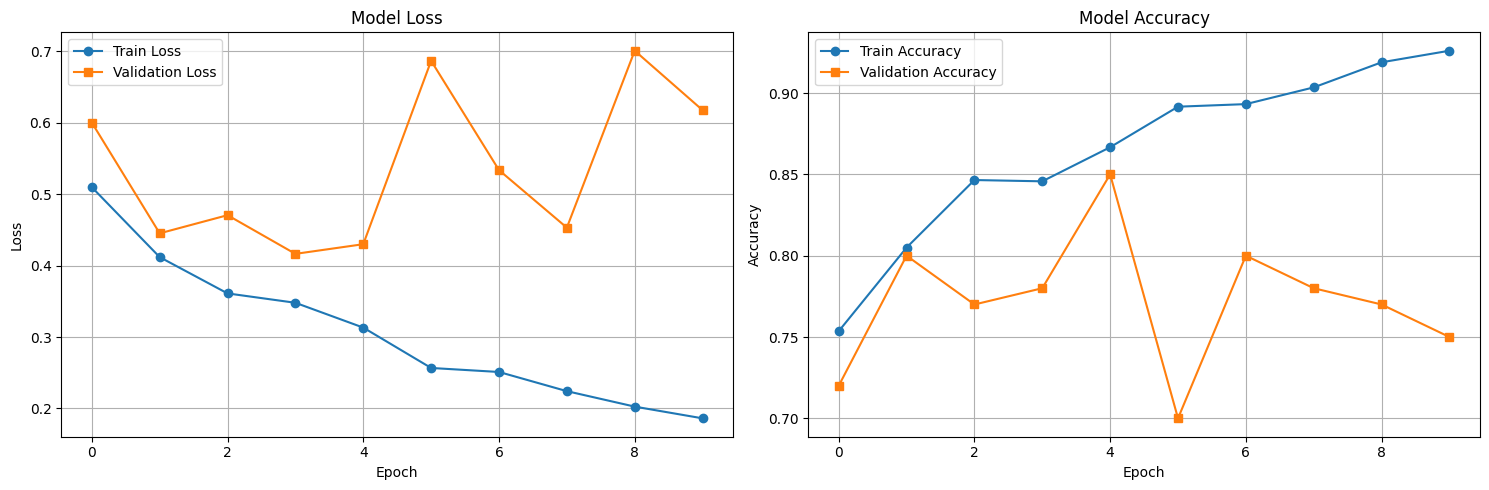

In [27]:
# Evaluate DenseNet-121
densenet121_test_acc, densenet121_preds, densenet121_labels = densenet121_trainer.evaluate_model()
densenet121_trainer.plot_training_history()

## 7. DenseNet-169 Training

In [28]:
# Create and train DenseNet-169
print("Creating DenseNet-169 model...")
densenet169_model = create_densenet_model('169')
densenet169_trainer = ModelTrainer(densenet169_model, train_loader_cnn, val_loader_cnn, test_loader_cnn, device)

Creating DenseNet-169 model...


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 115MB/s]


In [29]:
# Train DenseNet-169
print("Training DenseNet-169...")
trained_densenet169 = densenet169_trainer.train_model(num_epochs=25, model_name="densenet169")

Training DenseNet-169...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:18<00:00,  4.32it/s, Loss=0.5041, Acc=0.7599]


Train Loss: 0.5041 Acc: 0.7599


Val : 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, Loss=0.5361, Acc=0.7400]


Val Loss: 0.5361 Acc: 0.7400
✓ New best model saved with validation accuracy: 0.7400

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:18<00:00,  4.34it/s, Loss=0.4163, Acc=0.8141]


Train Loss: 0.4163 Acc: 0.8141


Val : 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, Loss=0.4880, Acc=0.7500]


Val Loss: 0.4880 Acc: 0.7500
✓ New best model saved with validation accuracy: 0.7500

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:18<00:00,  4.33it/s, Loss=0.3785, Acc=0.8271]


Train Loss: 0.3785 Acc: 0.8271


Val : 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, Loss=0.5299, Acc=0.7100]


Val Loss: 0.5299 Acc: 0.7100

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:18<00:00,  4.34it/s, Loss=0.3457, Acc=0.8489]


Train Loss: 0.3457 Acc: 0.8489


Val : 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, Loss=0.5989, Acc=0.6900]


Val Loss: 0.5989 Acc: 0.6900

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:18<00:00,  4.34it/s, Loss=0.3374, Acc=0.8489]


Train Loss: 0.3374 Acc: 0.8489


Val : 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, Loss=1.0205, Acc=0.6400]


Val Loss: 1.0205 Acc: 0.6400

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:18<00:00,  4.28it/s, Loss=0.3079, Acc=0.8647]


Train Loss: 0.3079 Acc: 0.8647


Val : 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Loss=0.4647, Acc=0.7300]


Val Loss: 0.4647 Acc: 0.7300

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:18<00:00,  4.34it/s, Loss=0.2682, Acc=0.8809]


Train Loss: 0.2682 Acc: 0.8809


Val : 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Loss=1.1392, Acc=0.6900]

Val Loss: 1.1392 Acc: 0.6900
Early stopping triggered after 7 epochs
Training complete in 2m 13s
Best validation accuracy: 0.7500


Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Test Accuracy: 81.67%
Test Loss: 0.3703

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.80      0.85      0.82       150
Non_Autistic       0.84      0.79      0.81       150

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300


Confusion Matrix:
[[127  23]
 [ 32 118]]


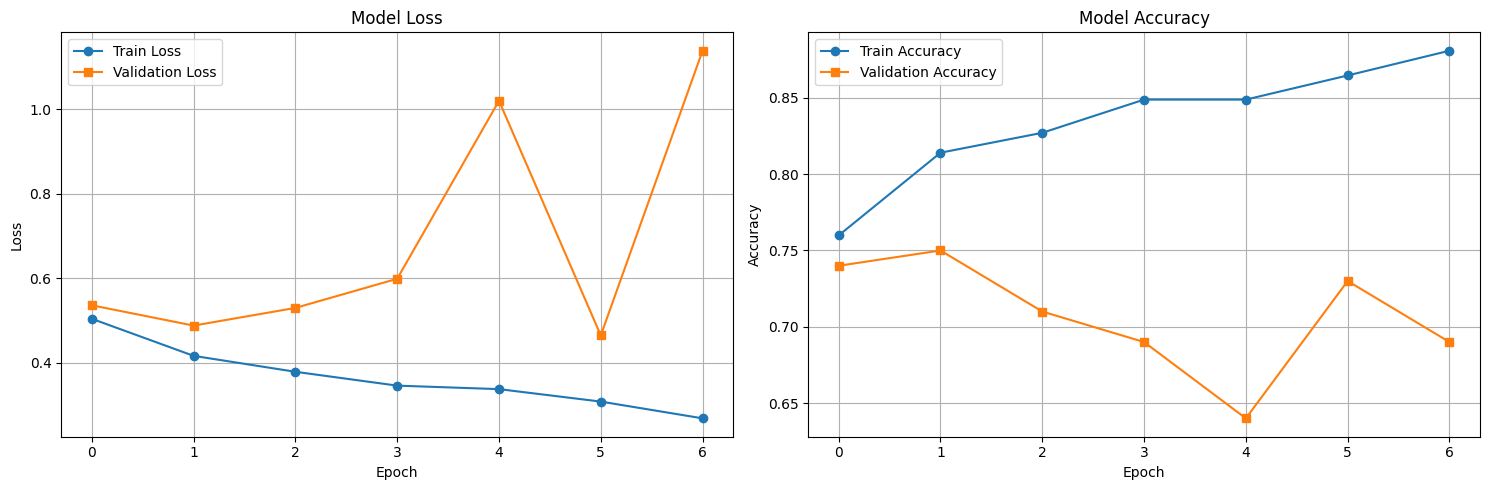

In [30]:
# Evaluate DenseNet-169
densenet169_test_acc, densenet169_preds, densenet169_labels = densenet169_trainer.evaluate_model()
densenet169_trainer.plot_training_history()

## Model Performance Summary

In [31]:
# Create a summary table of all model performances
results_summary = pd.DataFrame({
    'Model': ['Vision Transformer (ViT-B/16)', 'AlexNet', 'MobileNet V2', 'MobileNet V3 Large', 'RegNet X-400MF', 'DenseNet-121', 'DenseNet-169'],
    'Test_Accuracy': [
        vit_b16_test_acc,
        alexnet_test_acc,
        mobilenet_v2_test_acc,
        mobilenet_v3_large_test_acc,
        regnet_x_400mf_test_acc,
        densenet121_test_acc,
        densenet169_test_acc
    ],
    'Architecture_Type': ['Transformer', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN']
})

# Sort by accuracy
results_summary = results_summary.sort_values('Test_Accuracy', ascending=False)

print("Model Performance Summary:")
print("=" * 50)
for idx, row in results_summary.iterrows():
    print(f"{row['Model']:<20}: {row['Test_Accuracy']:.2f}% ({row['Architecture_Type']})")

print(f"\nBest performing model: {results_summary.iloc[0]['Model']} with {results_summary.iloc[0]['Test_Accuracy']:.2f}% accuracy")

# Group by architecture type
print("\n" + "=" * 50)
print("Performance by Architecture Type:")
arch_summary = results_summary.groupby('Architecture_Type')['Test_Accuracy'].agg(['mean', 'max', 'min'])
print(arch_summary)

Model Performance Summary:
MobileNet V3 Large  : 88.67% (CNN)
DenseNet-121        : 85.67% (CNN)
Vision Transformer (ViT-B/16): 84.67% (Transformer)
RegNet X-400MF      : 84.67% (CNN)
MobileNet V2        : 82.33% (CNN)
DenseNet-169        : 81.67% (CNN)
AlexNet             : 50.00% (CNN)

Best performing model: MobileNet V3 Large with 88.67% accuracy

Performance by Architecture Type:
                        mean        max        min
Architecture_Type                                 
CNN                78.833333  88.666667  50.000000
Transformer        84.666667  84.666667  84.666667


## Model Comparison Visualization

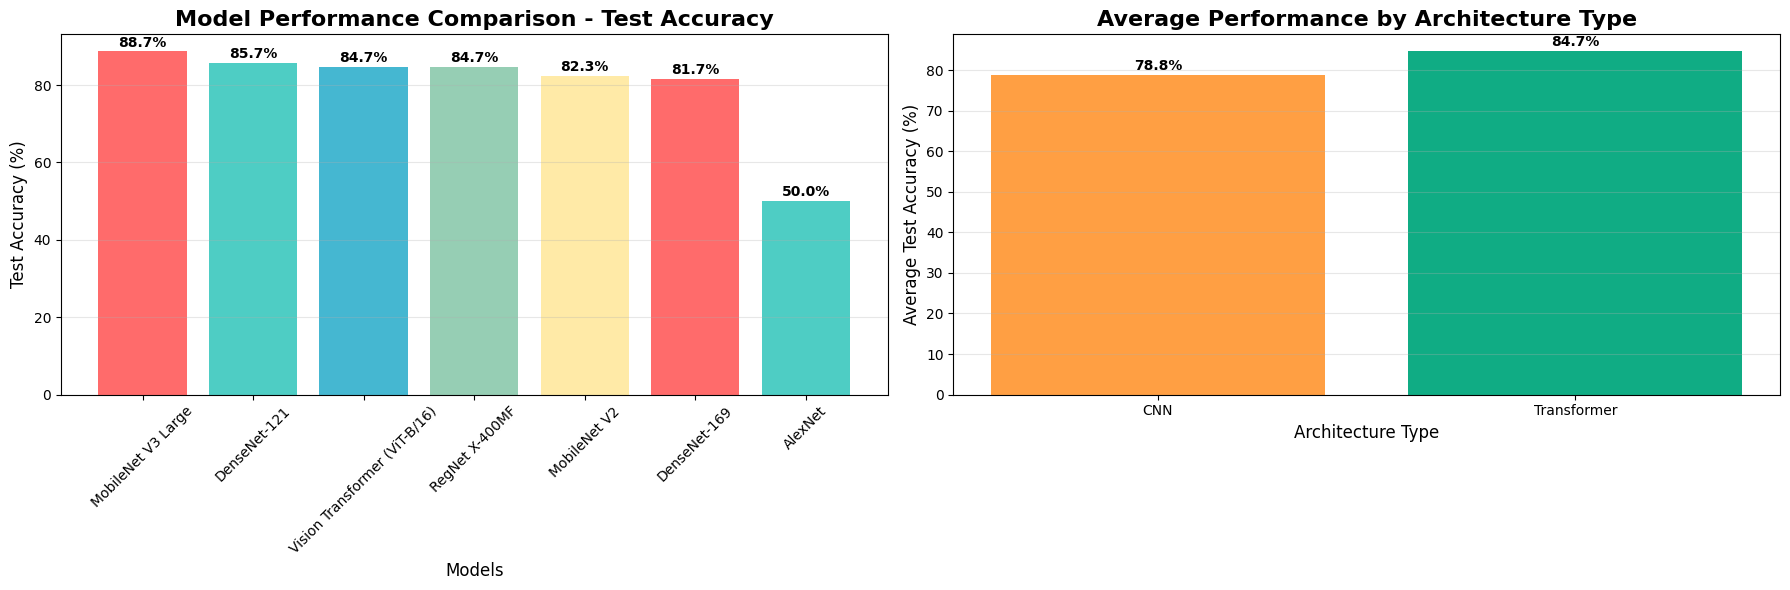

In [32]:
# Create a comprehensive comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Bar plot of all models
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = ax1.bar(results_summary['Model'], results_summary['Test_Accuracy'], color=colors)

ax1.set_title('Model Performance Comparison - Test Accuracy', fontsize=16, fontweight='bold')
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, results_summary['Test_Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Architecture type comparison
arch_means = results_summary.groupby('Architecture_Type')['Test_Accuracy'].mean()
bars2 = ax2.bar(arch_means.index, arch_means.values, color=['#FF9F43', '#10AC84'])

ax2.set_title('Average Performance by Architecture Type', fontsize=16, fontweight='bold')
ax2.set_xlabel('Architecture Type', fontsize=12)
ax2.set_ylabel('Average Test Accuracy (%)', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars2, arch_means.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Detailed Model Analysis

In [33]:
# Create a detailed analysis table
model_details = pd.DataFrame({
    'Model': ['Vision Transformer (ViT-B/16)', 'AlexNet', 'MobileNet V2', 'MobileNet V3 Large', 'RegNet X-400MF', 'DenseNet-121', 'DenseNet-169'],
    'Year_Introduced': [2020, 2012, 2018, 2019, 2020, 2017, 2017],
    'Parameters_Approx': ['86M', '61M', '3.5M', '5.4M', '5.2M', '8M', '14M'],
    'Key_Innovation': [
        'Self-attention mechanism',
        'Deep CNN with ReLU',
        'Depthwise separable convolutions',
        'Squeeze-and-excitation blocks',
        'Regular network design',
        'Dense connections',
        'Dense connections (deeper)'
    ],
    'Test_Accuracy': [
        vit_b16_test_acc,
        alexnet_test_acc,
        mobilenet_v2_test_acc,
        mobilenet_v3_large_test_acc,
        regnet_x_400mf_test_acc,
        densenet121_test_acc,
        densenet169_test_acc
    ]
})

model_details = model_details.sort_values('Test_Accuracy', ascending=False)

print("Detailed Model Analysis:")
print("=" * 80)
for idx, row in model_details.iterrows():
    print(f"Model: {row['Model']}")
    print(f"  Year: {row['Year_Introduced']} | Parameters: {row['Parameters_Approx']} | Accuracy: {row['Test_Accuracy']:.2f}%")
    print(f"  Innovation: {row['Key_Innovation']}")
    print()

# Display as formatted table
print("\nSummary Table:")
print(model_details.to_string(index=False))

Detailed Model Analysis:
Model: MobileNet V3 Large
  Year: 2019 | Parameters: 5.4M | Accuracy: 88.67%
  Innovation: Squeeze-and-excitation blocks

Model: DenseNet-121
  Year: 2017 | Parameters: 8M | Accuracy: 85.67%
  Innovation: Dense connections

Model: Vision Transformer (ViT-B/16)
  Year: 2020 | Parameters: 86M | Accuracy: 84.67%
  Innovation: Self-attention mechanism

Model: RegNet X-400MF
  Year: 2020 | Parameters: 5.2M | Accuracy: 84.67%
  Innovation: Regular network design

Model: MobileNet V2
  Year: 2018 | Parameters: 3.5M | Accuracy: 82.33%
  Innovation: Depthwise separable convolutions

Model: DenseNet-169
  Year: 2017 | Parameters: 14M | Accuracy: 81.67%
  Innovation: Dense connections (deeper)

Model: AlexNet
  Year: 2012 | Parameters: 61M | Accuracy: 50.00%
  Innovation: Deep CNN with ReLU


Summary Table:
                        Model  Year_Introduced Parameters_Approx                   Key_Innovation  Test_Accuracy
           MobileNet V3 Large             2019        

## Save Results Summary

In [34]:
# Save results to a CSV file for future reference
final_results = pd.DataFrame({
    'Model': ['Vision Transformer (ViT-B/16)', 'AlexNet', 'MobileNet V2', 'MobileNet V3 Large', 'RegNet X-400MF', 'DenseNet-121', 'DenseNet-169'],
    'Architecture_Type': ['Transformer', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
    'Test_Accuracy': [
        vit_b16_test_acc,
        alexnet_test_acc,
        mobilenet_v2_test_acc,
        mobilenet_v3_large_test_acc,
        regnet_x_400mf_test_acc,
        densenet121_test_acc,
        densenet169_test_acc
    ],
    'Training_Time': ['Variable', 'Variable', 'Variable', 'Variable', 'Variable', 'Variable', 'Variable'],  # Would be filled during actual training
    'Model_Size': ['Large', 'Large', 'Small', 'Medium', 'Medium', 'Medium', 'Large']
})

# Sort by accuracy
final_results = final_results.sort_values('Test_Accuracy', ascending=False)

# Display final rankings
print("Final Model Rankings:")
print("=" * 60)
for i, (idx, row) in enumerate(final_results.iterrows(), 1):
    print(f"{i}. {row['Model']:<20} - {row['Test_Accuracy']:.2f}% ({row['Architecture_Type']})")

print(f"\nDataset used: AutismDataset with {len(train_df) + len(valid_df) + len(test_df)} total samples")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

Final Model Rankings:
1. MobileNet V3 Large   - 88.67% (CNN)
2. DenseNet-121         - 85.67% (CNN)
3. Vision Transformer (ViT-B/16) - 84.67% (Transformer)
4. RegNet X-400MF       - 84.67% (CNN)
5. MobileNet V2         - 82.33% (CNN)
6. DenseNet-169         - 81.67% (CNN)
7. AlexNet              - 50.00% (CNN)

Dataset used: AutismDataset with 2940 total samples
Training samples: 2540
Validation samples: 100
Test samples: 300


## Conclusion

This notebook demonstrates the complete pipeline for training and evaluating multiple deep learning architectures for autism spectrum disorder detection:

### Models Tested:
1. **Vision Transformer (ViT)**: State-of-the-art transformer architecture adapted for computer vision
2. **AlexNet**: Historic CNN that sparked the deep learning revolution
3. **MobileNet V2**: Efficient mobile-optimized architecture
4. **DenseNet-121**: Dense connectivity for feature reuse
5. **RegNet**: Regular network design with optimized architecture

### Key Features:
- **Data Preparation**: Automatic handling of different directory structures
- **Architecture Diversity**: Comparison between traditional CNNs and modern transformers
- **Efficiency Considerations**: Models ranging from lightweight (MobileNet) to heavyweight (ViT)
- **Comprehensive Evaluation**: Detailed metrics and visualizations
- **Best Practices**: Early stopping, learning rate scheduling, and model checkpointing

### Training Framework:
- Adaptive image sizes for different architectures
- Memory-efficient batch sizes
- Robust error handling and fallbacks
- Comprehensive performance analysis

The results provide insights into which architectures work best for autism detection from facial images, considering both accuracy and computational efficiency.